# Gifts recommendation
Everybody (of those whom we asked) googled something like "what to gift to smb on someday?". The idea is to create the recommendation system which tells you what to present based on some answers from the poll. We wanted to try this idea a long time ago:
1. Gather data
2. Try to apply ml
3. Wrap the code as a product
And this is what we have at this moment.

For the first step we decided to use Yandex.Толока (toloka.yandex.ru) service as it's cheap and there are fair enough russian-speaking people. We developed the poll which consists of these questions (without answers, because it would be messy):
1. Have you made a gift to a woman or a man? (person_gender)
2. What is the age of this person (at least approximately, at the time of donation) (person_age)
3. Which animals do you prefer to the person to whom you want to make a gift? (person_animals_like)
4. Does the person to whom you made the gift have pets? (person_animals)
5. How long were you acquainted with the person who made the gift at that time? (person_time)
6. How close are you to the person who made the gift (person_closeness)
7. Is the person to whom you have made a gift engaged in sports (any physical activity), if so, which one? (person_sport)
8. What music is listening? (person_music)
9. Does the person you want to give a gift drive a car? (person_auto)
10. What is the mindset of this person? (person_mental)
11. How tall is this man? (person_height)
12. How long is his hair? (person_hair)
13. What is his hair color? (person_hair_color)
14. Chronotype? (person_chronotype)
15. What kind of phone does a person use? (person_tel)
16. Education (person_education)
17. Is this person open and talkative, easy to get along with new people? (person_psycho_1)
18. Is this person leisurely, restrained in communication, alert to new people? (person_psycho_2)
19. Does this person be a realist and pragmatist, who prefers the old and the proven to the new? (person_psycho_3)
20. Does this person tend to trust his intuition, prefers the new to the old? (person_psycho_4)
21. Does this person put logic above feelings, judge people regardless of sympathy for them? (person_psycho_5)
22. Does this person tend to make compromises in matters for the sake of harmonious relations, trust his feelings? (person_psycho_6)
23. Is this person consistent in his work, he makes decisions unambiguously and does not like to change them? (person_psycho_7)
24. Can this person flexibly adapt to new conditions? (person_psycho_8)
25. Does this person tolerate formalism? (person_psycho_9)
26. Does this person have a hobby? (person_hobby)
27. Where does a person work? (person_work)
28. How often does he browse media content? (person_social)
29. What is the temperament of this person? (person_temperament)
30. Describe the character of the person to whom you made a gift in one word (person_character_word)
31. Describe the appearance of this person in one word (person_appearance_word)
32. Describe the communication of this person in one word (person_communication_word)
33. Describe what best describes the individuality of this person, in one word (person_individuality_word)
34. Describe the person to whom you made a gift, at least 100 characters of the text (it may be just a set of words characterizing the person) (person_description_text)
35. How much net time did you need to choose a gift? (self_time)
36. How many different options have you considered? (self_variants)
37. Gift Value (self_wish_to_give)
38. You first gave something to this person? If not, what kind of gift is this? (self_gift_times)
39. Your floor (self_gender)
40. How old were you at that time? (self_age)
41. Is your gift this electronic device? (self_gift_desc_1)
42. Estimate the frequency of use of the gift for its intended purpose? (self_gift_desc_2)
43. Evaluate the aesthetic component of the possession of the subject of the gift (self_gift_desc_3)
44. Does the gift relate to clothes? (self_gift_desc_4)
45. Where is your gift used? (self_gift_desc_5)
46. Estimate the size of your gift (self_gift_desc_6)
47. Is your gift edible? (self_gift_value_7)
48. How long do they use such gifts? (self_gift_desc_8)
49. Is the gift intended for single use? (self_gift_desc_9)
50. A gift made by hand? (self_gift_desc_10)
51. How much is your gift multifunctional? (self_gift_desc_11)
52. Your gift can be attributed to the premium class? (self_gift_desc_12)
53. What part of the people from the environment of the person to whom you made the gift had such a thing? (self_gift_desc_13)
54. To what extent did a person like your gift in words (categories) (self_gift_mark)
55. How much man liked your gift. Rating from 1 to 100 (self_gift_mark_2)
56. Is your present gift used? (self_gift_usage)
57. Is your gift being misused? (self_gift_bad_usage)
58. What is the gift (name)? (self_gift_name)
59. Leave a link to it (if any) (optional) (self_gift_link)

After collecting and validation (removing fraud) of the data, we have left 935 answers. Every instance was validated by hands, because otherwise it's really hard to deal with bots. We tried different versions of our poll. The main difference of this version is presence of self_gift_desc_* fields. Firstly, we tried to use constant number of categories (and we did, for tests), but we were not sure if we listed the most popular of them. So we've decided to create some questions which will approximate the category. So, each distinct combination of self_gift_desc_* answers is the category of a gift.

Also we wanted to have enough features from fields where you need to choose the variant, but maybe it's possible to gather the same information just from the description of the person, so we added text fields.

We decided to solve the task this way
1. target column is self_gift_mark_2
2. So it is a Regression
3. Algorithm of recommendation producing:
    a. Train model
    b. Get the instance
    c. Consequently change the set of self_gift_desc_* features
    d. For each combination predict the score with trained model
    e. Use argmax to get desired combination of self_gift_desc_* features
    f. Get all of the examples we have in our dataset with this combination

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline  

In [2]:
data = pd.read_csv('./gifts-data.tsv', delimiter='\t')

#dropping invalid rows (every second BTW)
data = data.drop([i for i in range (1, len(data), 2)], axis=0)

#droppint working columns
to_drop = ['INPUT:theme', 'ASSIGNMENT:link', 'ASSIGNMENT:assignment_id', 'ASSIGNMENT:worker_id',
           'ASSIGNMENT:status', 'ASSIGNMENT:started', 'ACCEPT:verdict', 'ACCEPT:comment']
data = data.drop(to_drop, axis=1)

#dropping fully nan columns
for col in data.columns:
    nan_ = sum(data[col].isnull())
    if nan_ == len(data):
        data = data.drop([col], axis=1)

#checking out what's left
for key, value in data.iloc[0].iteritems():
    print (key, value)

OUTPUT:self_age 53.0
OUTPUT:self_time 2.0
OUTPUT:person_age 56.0
OUTPUT:person_tel 2.0
OUTPUT:person_auto 0.0
OUTPUT:person_hair 0.0
OUTPUT:person_time 7.0
OUTPUT:person_work 2.0
OUTPUT:self_gender 1.0
OUTPUT:person_hobby 0.0
OUTPUT:person_music 4.0
OUTPUT:person_sport 0.0
OUTPUT:person_gender 1.0
OUTPUT:person_height 3.0
OUTPUT:person_mental 0.0
OUTPUT:person_social 2.0
OUTPUT:self_variants 1.0
OUTPUT:person_animals 1.0
OUTPUT:self_gift_link nan
OUTPUT:self_gift_mark 0.0
OUTPUT:self_gift_name Аккустическая система с фм
OUTPUT:person_psycho_1 1.0
OUTPUT:person_psycho_2 0.0
OUTPUT:person_psycho_3 0.0
OUTPUT:person_psycho_4 0.0
OUTPUT:person_psycho_5 0.0
OUTPUT:person_psycho_6 0.0
OUTPUT:person_psycho_7 0.0
OUTPUT:person_psycho_8 1.0
OUTPUT:person_psycho_9 1.0
OUTPUT:self_gift_times 6.0
OUTPUT:self_gift_usage 0.0
OUTPUT:person_closeness 4.0
OUTPUT:person_education 1.0
OUTPUT:self_gift_desc_1 0.0
OUTPUT:self_gift_desc_2 0.0
OUTPUT:self_gift_desc_3 1.0
OUTPUT:self_gift_desc_4 1.0
OUTPUT:se

In [3]:
# dropping text features (but not gift description)
text_like = ['OUTPUT:person_character_word', 'OUTPUT:person_appearance_word', 'OUTPUT:person_description_text',
            'OUTPUT:person_communication_word', 'OUTPUT:person_individuality_word', 'OUTPUT:self_gift_link',]

# dataframe with text fields
# we'll use it later
tdata = data[text_like]
tdata = tdata.drop('OUTPUT:self_gift_link', axis=1)

data = data.drop(text_like, axis=1) #at the start we do not really need it

#gift description drop
data = data.drop(['OUTPUT:self_gift_name'], axis=1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 44 Text xticklabel objects>)

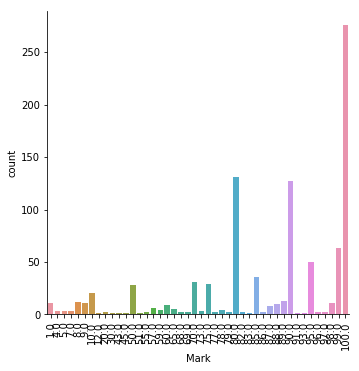

In [696]:
# marks distribution
sns.catplot(x='Mark', kind='count', data=pd.DataFrame(data['OUTPUT:self_gift_mark_2'].values, columns=['Mark']), )
plt.xticks(rotation=90)


We used 1 (very bad) to 100 (very good) mark to get three peaks: 80, 90, 100, which corresponds to 3,4,5 marks if five-graded marks system. If we used, we would hardly have received these three peaks. 

It's also interesting that some people understood the question "vice versa". In their mind 1 is very good and 100 is very bad (as places on a pedestal). 

And some people didn't see that it's 1 to 100 and filled 10 as 100, 9 as 90... We'll deal with it later

Now let's implement simple baseline solution for our problem

# Encoding

In [4]:
additional_drops = ['OUTPUT:self_gift_mark', 'OUTPUT:self_variants', 'OUTPUT:self_gift_times', 'OUTPUT:self_gift_usage',
                    'OUTPUT:self_gift_bad_usage']
data = data.drop(additional_drops, axis=1)


for key, value in data.iloc[0].iteritems():
    print (key, value)

OUTPUT:self_age 53.0
OUTPUT:self_time 2.0
OUTPUT:person_age 56.0
OUTPUT:person_tel 2.0
OUTPUT:person_auto 0.0
OUTPUT:person_hair 0.0
OUTPUT:person_time 7.0
OUTPUT:person_work 2.0
OUTPUT:self_gender 1.0
OUTPUT:person_hobby 0.0
OUTPUT:person_music 4.0
OUTPUT:person_sport 0.0
OUTPUT:person_gender 1.0
OUTPUT:person_height 3.0
OUTPUT:person_mental 0.0
OUTPUT:person_social 2.0
OUTPUT:person_animals 1.0
OUTPUT:person_psycho_1 1.0
OUTPUT:person_psycho_2 0.0
OUTPUT:person_psycho_3 0.0
OUTPUT:person_psycho_4 0.0
OUTPUT:person_psycho_5 0.0
OUTPUT:person_psycho_6 0.0
OUTPUT:person_psycho_7 0.0
OUTPUT:person_psycho_8 1.0
OUTPUT:person_psycho_9 1.0
OUTPUT:person_closeness 4.0
OUTPUT:person_education 1.0
OUTPUT:self_gift_desc_1 0.0
OUTPUT:self_gift_desc_2 0.0
OUTPUT:self_gift_desc_3 1.0
OUTPUT:self_gift_desc_4 1.0
OUTPUT:self_gift_desc_5 0.0
OUTPUT:self_gift_desc_6 2.0
OUTPUT:self_gift_desc_7 1.0
OUTPUT:self_gift_desc_8 2.0
OUTPUT:self_gift_desc_9 1.0
OUTPUT:self_gift_mark_2 100.0
OUTPUT:person_chron

In [5]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer

Y = data['OUTPUT:self_gift_mark_2']
X = data.drop('OUTPUT:self_gift_mark_2', axis=1) 

leave = ['OUTPUT:person_age', 'OUTPUT:self_age']
to_onehot = X.drop(['OUTPUT:person_age', 'OUTPUT:self_age'], axis=1).columns.values

onehotencoded = pd.get_dummies(X[to_onehot].astype(str))

to_binarize = []

def binarize_column(data , column):
    un = data[column].unique()
    un_dict = {v:k for k, v in enumerate(un)}
    data[column] = data[column].apply(lambda x: un_dict[x])
   
def binarize_set(data):
    for col in data.columns:
        binarize_column(data, col)
    
binarized = data[to_binarize].copy()
binarize_set(binarized)

In [6]:
len(to_onehot) + len(leave) == len(X.columns)

True

In [7]:
X_encoded = pd.concat([onehotencoded, X[leave]], axis=1)

# Missing values

In [8]:
for col in X_encoded.columns:
    nan_ = sum(X_encoded[col].isnull())
    if nan_ > 0:
        print (col, nan_/float(len(X_encoded)))

No missing values. Pretty situation.

First approach. Just encoded values and random forest.

In [9]:
from sklearn.model_selection import GridSearchCV

def score_params(*data, param_grid):
    X, Y = data
    rfr=RandomForestRegressor(random_state=42)

    

    CV_rfc = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 10)
    CV_rfc.fit(X, Y)

    print (CV_rfc.best_params_)
    rfr=RandomForestRegressor(random_state=42)
    rfr.set_params(**CV_rfc.best_params_)
    mean, std = perform_n_cv(rfr, X, Y, cv_count=10, scoring=make_scorer(mean_squared_error), iterations=10)
    print (mean, '+-' ,std)
    
def perform_n_cv(clf, x, y, cv_count, scoring, iterations):
    cv_accumulator = []
    for i in range(iterations):
        cv = cross_val_score(clf, x, y, cv=cv_count, scoring=scoring)
        cv_accumulator.append([np.mean(np.sqrt(cv)), np.std(np.sqrt(cv))])
        
    return np.mean(np.array(cv_accumulator)[:, 0]), np.mean(np.array(cv_accumulator)[:, 1])

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

score_params(X_encoded, Y,
             param_grid = {'n_estimators': [15, 20, 25, 30, 40],
                           'max_depth' : [1, 2, 3, 4, 5, None]})

{'n_estimators': 20, 'max_depth': 2}
23.94992836983369 +- 3.5656563509999786


In [13]:
clf = RandomForestRegressor(random_state=42, max_depth=2, n_estimators=20)
clf.fit(X_encoded, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Let's see feature importance

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

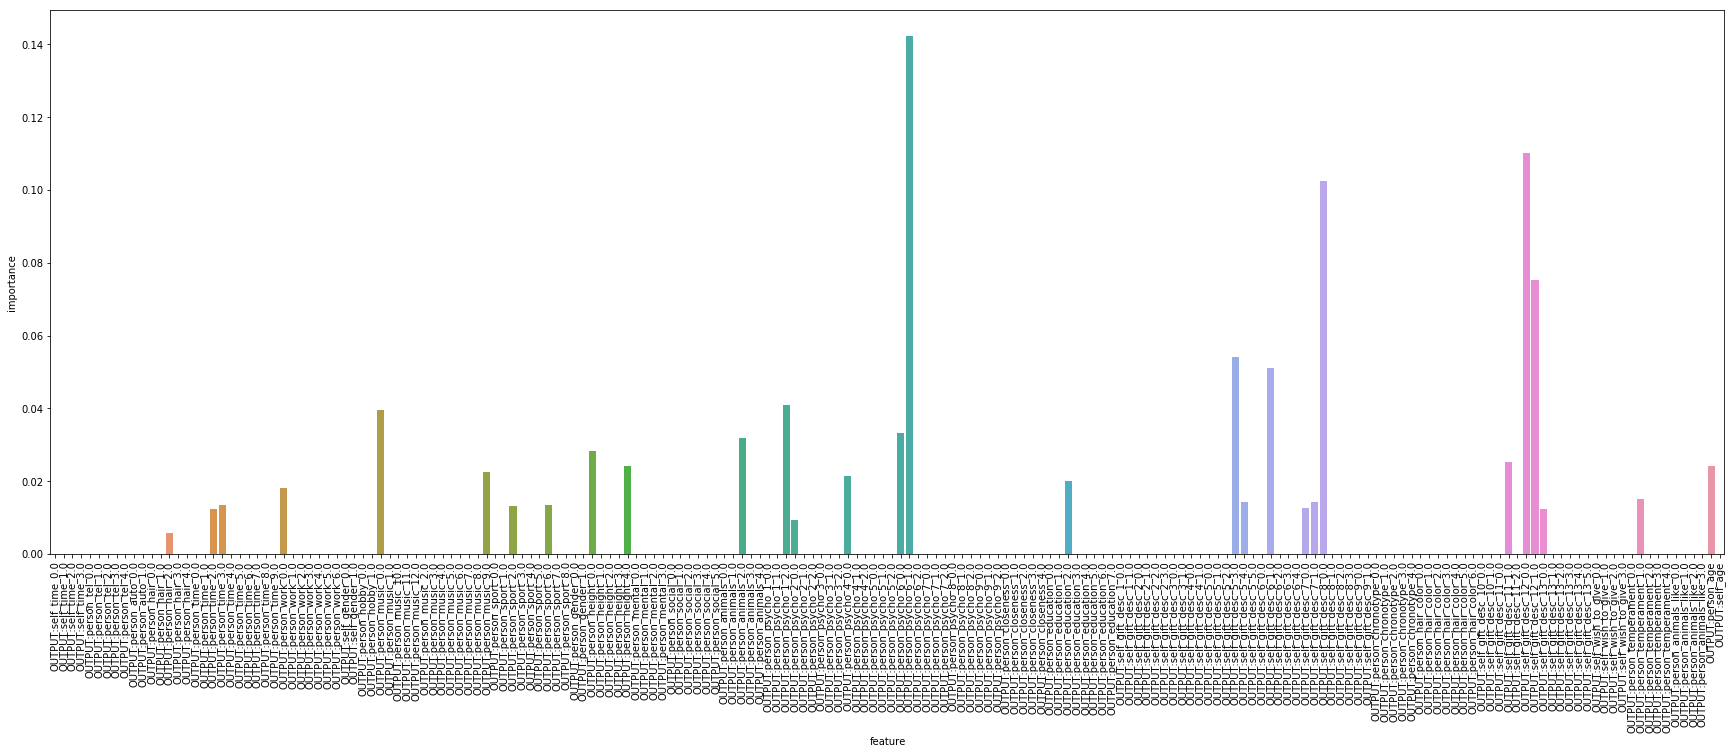

In [20]:
from matplotlib import pyplot
dims = (30.0, 10.0)
fig, ax = pyplot.subplots(figsize=dims)
g= sns.barplot(ax=ax, x='feature', y='importance', data=pd.DataFrame(list(zip(clf.feature_importances_, X_encoded.columns)), columns=['importance', 'feature']))
plt.xticks(rotation=90)

In [26]:
f_importance = pd.DataFrame(list(zip(clf.feature_importances_, X_encoded.columns)), columns=['importance', 'feature'])
f_importance.sort_values(by=['importance'], ascending=False).head(10)

,importance,feature
97,0.142297,OUTPUT:person_psycho_6_1.0
167,0.110145,OUTPUT:self_gift_desc_12_0.0
144,0.102417,OUTPUT:self_gift_desc_8_0.0
168,0.075257,OUTPUT:self_gift_desc_12_1.0
134,0.054030,OUTPUT:self_gift_desc_5_3.0
138,0.051024,OUTPUT:self_gift_desc_6_1.0
83,0.040979,OUTPUT:person_psycho_1_2.0
37,0.039462,OUTPUT:person_music_0.0
96,0.033335,OUTPUT:person_psycho_6_0.0
78,0.031734,OUTPUT:person_animals_2.0


We can see that not only self_gift_desc_* features are important to make predictions

### Distribution naive changes
Now let's change the distribution in target column, according to our previous comment

In [29]:
X_encoded_themes = X_encoded.copy()

y_frame = pd.DataFrame(Y.values, columns=['target']).set_index(keys=X_encoded.index)
y_frame[y_frame.target <= 10] = y_frame[y_frame.target <= 10]*10
X_encoded = X_encoded.drop(y_frame[y_frame.target < 50].index)
y_frame = y_frame.drop(y_frame[y_frame.target < 50].index)

In [30]:
y_frame.head(5)

,target
0,100.0
2,100.0
4,80.0
6,80.0
8,80.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text xticklabel objects>)

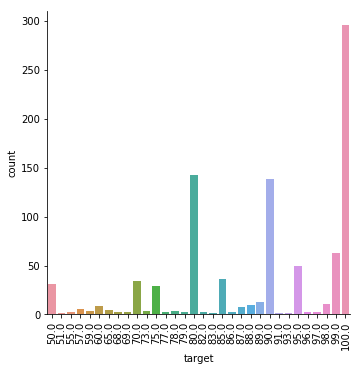

In [38]:
sns.catplot(x='target', kind='count', data=y_frame) 
plt.xticks(rotation=90)

Again, let's make some hyperparameters searching...

In [64]:
score_params(X_encoded, y_frame.target,
             param_grid = {'n_estimators': [45, 50, 55, 60, 65, 70],
                           'max_depth' : [2, 3, 4, 5, 6, None]})

score_params(X_encoded, y_frame.target,
             param_grid = {'n_estimators': [65, 68, 71, 74, 77, 80, 83],
                           'max_depth' : [3, 4, 5, None]})

score_params(X_encoded, y_frame.target,
             param_grid = {'n_estimators': [72, 73, 74, 75, 76],
                           'max_depth' : [3, 4, 5, None]})

GridSearch didn't get us a big breakthrough but the distribution change did. These are optimal parameters

In [65]:
score_params(X_encoded, y_frame.target,
             param_grid = {'n_estimators': [75],
                           'max_depth' : [4, None]})

/home/kefir/miniconda3/envs/diploma/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 4, 'n_estimators': 75}
12.3049884047 +- 1.7032316923


## lasso ridge check
Let's try another type of models. Motivation: we want fields like self_gift_desc_* to contribute less, because otherwise category dominates in prediction, not the person

In [50]:
from sklearn.linear_model import Lasso, Ridge
def score_params(*data, model, param_grid):
    X, Y = data
    rfr=model#Lasso(random_state=42)

    

    CV_rfc = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 10)
    CV_rfc.fit(X, Y)

    print (CV_rfc.best_params_)
    rfr=model#Lasso(random_state=42)
    rfr.set_params(**CV_rfc.best_params_)
    mean, std = perform_n_cv(rfr, X, Y, cv_count=10, scoring=make_scorer(mean_squared_error), iterations=10)
    print (mean, '+-' ,std)

In [51]:
score_params(X_encoded, y_frame.target, model=Ridge(random_state=42),
             param_grid = {'alpha': [0.01, 0.1, 1, 10, 20, 50, 100, 500, 1000]})

/home/dmitriy/MyEnv/other/skoltech/intro-to-ds/env/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 500}
12.223857850695477 +- 1.8028469780582683


In [52]:
reg = Lasso(random_state=42, alpha=0.1)
reg.fit(X_encoded, y_frame.target)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)

In [53]:
coefs = pd.DataFrame(list(zip(reg.coef_, X_encoded.columns)), columns=['coef', 'name'])
coefs[np.abs(coefs.coef) > 1.5]

,coef,name
28,1.701450,OUTPUT:person_work_2.0
33,-1.651739,OUTPUT:self_gender_0.0
35,2.298114,OUTPUT:person_hobby_0.0
46,-2.108517,OUTPUT:person_music_6.0
54,-2.460420,OUTPUT:person_sport_4.0
96,2.238793,OUTPUT:person_psycho_6_0.0
107,2.487853,OUTPUT:person_psycho_9_2.0
125,-3.141013,OUTPUT:self_gift_desc_2_2.0
135,1.983203,OUTPUT:self_gift_desc_5_4.0
138,-1.790005,OUTPUT:self_gift_desc_6_1.0


Fine, so now self_gift_desc_* features are valuable, but not the most

## Recomendation system building
Here you can see the functinality to make predictions

In [55]:
def get_samples(pool, dataset, description, descr_columns):
    condition = [True for i in range(len(dataset))]
    for desc, col in zip(description, descr_columns):
        condition = condition & (dataset[col]==desc)
        
    return pool[condition].values[0]
        

In [56]:
# check if function is working
pool_building = pd.read_csv('./gifts-data.tsv', delimiter='\t')
pool =  pool_building['OUTPUT:self_gift_name']
pool = pool[pool.index.isin(X_encoded.index)]

description_columns = X_encoded.columns[X_encoded.columns.str.contains('self_gift_desc_')]

sample_description = X_encoded.iloc[0][description_columns].values

get_samples(pool, X_encoded, sample_description, description_columns)

'Аккустическая система с фм'

In [57]:
descriptions_from_pool = X_encoded[description_columns].drop_duplicates()

def rate_descriptions(model, descriptions_from_pool, person_description, description_columns):
    '''
    Person description must contain columns for present descriptions 'cause I'm lazy bastard
    '''
    rated = descriptions_from_pool.copy()
    rated['rating'] = [0 for i in range(len(rated))]
    for x in descriptions_from_pool.iterrows():
        description = x[1].values
        current_sample = person_description.copy()
        current_sample[description_columns] = description
        
        prediction = model.predict([current_sample.values])
        
        rated.loc[x[0], 'rating'] = prediction
        
    return rated

def get_proposals(model, dataset, person_description, description_columns, pool):
    rating = rate_descriptions(model,  dataset[description_columns], person_description, description_columns)
    rating = rating.sort_values('rating', ascending=False).reset_index()
    
    proposals = []
    for sample in rating.iloc[:10].iterrows():
        proposals.append(get_samples(pool,
                                     dataset,
                                     sample[1].drop(labels=['rating']).values[1:],
                                     description_columns))
        
    return list(set(map(lambda x: x.lower(), proposals)))

In [60]:
reg = RandomForestRegressor(random_state=42, max_depth=4, n_estimators=75)
reg.fit(X_encoded, y_frame.target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [62]:
get_proposals(reg, X_encoded, X_encoded.iloc[650], description_columns, pool) # change .iloc[*number*] to get another results
#iloc 5 - ребенок

['ребенок',
 'браслет',
 'браслет золотой',
 'украшение',
 'macbook pro',
 'кольцо из белого золота',
 'смартфон',
 'швейцарские механические часы с календарем',
 'часы мужские дизель',
 'браслет пандора']

# Thematic modelling
We added some features based on thematic modelling. We created simple LDA model with 10 themes, based on our text fields. The features are "the presence of each theme in the text". Let's see if it helps us to solve our task

In [64]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import operator
import pymorphy2
import gensim
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dmitriy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
res = []
for idx, row in tdata.iterrows():
    s = ""
    for col in tdata.columns:
        s += row[col].lower() + ' '
    s = s.replace(',', '')
    s = s.replace('  ', '')
    res.append(s)

In [66]:
def return_thematic_features(model, doc_set):
    tokenizer = RegexpTokenizer(r'\w+')

    ru_stop = stopwords.words('russian')

    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    
    morph = pymorphy2.MorphAnalyzer()
    # list for tokenized documents in loop
    texts = []
    token_counts = {}
    sum_counts = 0
    docs_tokens = []
    # loop through document list
    for idx in range(len(doc_set)):
        # clean and tokenize document string
        raw = doc_set[idx].lower()
        tokens = tokenizer.tokenize(raw)
        # уборка частых слов уже после токенизации осознанна
        for elem in tokens:
            if elem in token_counts:
                token_counts[elem] += 1
            else:
                token_counts[elem] = 1
            sum_counts += 1
        docs_tokens.append(tokens)

    sorted_counts = sorted(token_counts.items(), key=operator.itemgetter(1))
    #sorted_counts.reverse()

    summator = 0
    sum_counts_fl = float(sum_counts)
    for idx in range(len(sorted_counts)):
        if summator / sum_counts_fl < float(0.4): # отсеиваемая доля
            summator += sorted_counts[idx][1]
            ru_stop.append(sorted_counts[idx][0])
        else:
            break 

    for idx in range(len(doc_set)):
        tokens = docs_tokens[idx]
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in ru_stop]
        # stem tokens
        #stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]

        # add tokens to list
        texts.append(stopped_tokens)
        
    normalized_texts = []
    for elem in texts:
        new = []
        for w in elem:
            p = morph.parse(w)[0]
            new.append(p.normal_form)
        normalized_texts.append(new)
        
    features = []
    for text in texts:
        answ = dict()
        for i in range(model.num_topics):
            answ['thematic_'+str(i)] = 0.0
        dictionary = model.id2word
        pred = dictionary.doc2bow(text)
        for elem in model[pred]:
            answ['thematic_'+str(elem[0])] = float(elem[1])
        features.append(answ)
    return features

In [68]:
m = gensim.models.LdaModel.load("10/results.model")
thematic_features = return_thematic_features(m, res)
tdata_features = pd.DataFrame(thematic_features)
tdata_features.head(5)

,thematic_0,thematic_1,thematic_2,thematic_3,thematic_4,thematic_5,thematic_6,thematic_7,thematic_8,thematic_9
0,0.107554,0.000000,0.464233,0.000000,0.253505,0.000000,0.120155,0.000000,0.000000,0.000000
1,0.014287,0.014288,0.014291,0.871402,0.014288,0.014286,0.014294,0.014286,0.014286,0.014292
2,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.887497,0.012500,0.012501,0.012501
3,0.720953,0.000000,0.000000,0.138126,0.000000,0.000000,0.000000,0.000000,0.087070,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.791075,0.151775,0.000000,0.000000,0.000000


In [69]:
X_encoded_themes.shape

(935, 190)

In [70]:
tdata_features.shape


(935, 10)

In [80]:
X_encoded_themes_index_reset = X_encoded_themes.reset_index().drop('index', axis=1)

In [85]:
X_encoded_themes = pd.concat([X_encoded_themes_index_reset, tdata_features.reset_index()], axis=1)

In [86]:
y_frame_themes = pd.DataFrame(Y.values, columns=['target']).reset_index()
#X_encoded_themes = X_encoded_themes.reset_index()
y_frame_themes[y_frame_themes.target <= 10] = y_frame_themes[y_frame_themes.target <= 10]*10
X_encoded_themes = X_encoded_themes.drop(y_frame_themes[y_frame_themes.target < 50].index)
y_frame_themes = y_frame_themes.drop(y_frame_themes[y_frame_themes.target < 50].index)

In [87]:
for col in data.columns[data.columns.str.contains('desc')]:
    print (col, [len(data[data[col]==i]) for i in range(5)])

OUTPUT:self_gift_desc_1 [292, 643, 0, 0, 0]
OUTPUT:self_gift_desc_2 [466, 309, 72, 88, 0]
OUTPUT:self_gift_desc_3 [642, 293, 0, 0, 0]
OUTPUT:self_gift_desc_4 [156, 779, 0, 0, 0]
OUTPUT:self_gift_desc_5 [332, 38, 27, 18, 474]
OUTPUT:self_gift_desc_6 [119, 387, 374, 40, 15]
OUTPUT:self_gift_desc_7 [43, 892, 0, 0, 0]
OUTPUT:self_gift_desc_8 [55, 157, 524, 199, 0]
OUTPUT:self_gift_desc_9 [155, 780, 0, 0, 0]
OUTPUT:self_gift_desc_10 [95, 840, 0, 0, 0]
OUTPUT:self_gift_desc_11 [544, 156, 235, 0, 0]
OUTPUT:self_gift_desc_12 [273, 662, 0, 0, 0]
OUTPUT:self_gift_desc_13 [121, 293, 215, 121, 129]


In [88]:
columns_to_drop = []
columns_to_drop.append(X_encoded_themes.columns[X_encoded_themes.columns.str.contains('desc_4|desc_7|desc_9|desc_10')])
score_params(X_encoded_themes.drop(columns_to_drop[0], axis=1), y_frame_themes.target, model=RandomForestRegressor(random_state=42),
             param_grid = {'n_estimators': [15, 20, 25, 30, 40],
                           'max_depth' : [1, 2, 3, 4, 5, None]})

/home/dmitriy/MyEnv/other/skoltech/intro-to-ds/env/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 40, 'max_depth': 4}
12.291087573279869 +- 1.618183910285398


The results are comparable with previous but the variance is lower. Let's see what we can predict

In [92]:
theme_regressor = RandomForestRegressor(random_state=42, max_depth=4, n_estimators=40)
theme_regressor.fit(X_encoded_themes, y_frame_themes.target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [116]:
tmp = X_encoded_themes.reset_index().drop('index', axis=1)

In [118]:
get_proposals(theme_regressor, tmp, tmp.iloc[650], description_columns, pd.Series(pool.reset_index().drop('index', axis=1).values.reshape((915,)))) 

['спиннинг',
 'мобильный телефон bq stanford и парфюм',
 'ноутбук',
 'телефон samsung a5',
 'смартфон',
 'ювелирное украшение',
 'настольная игра',
 'кепка']

(-11.100000000000009, 211.1, 0.0, 0.09872863620669559)

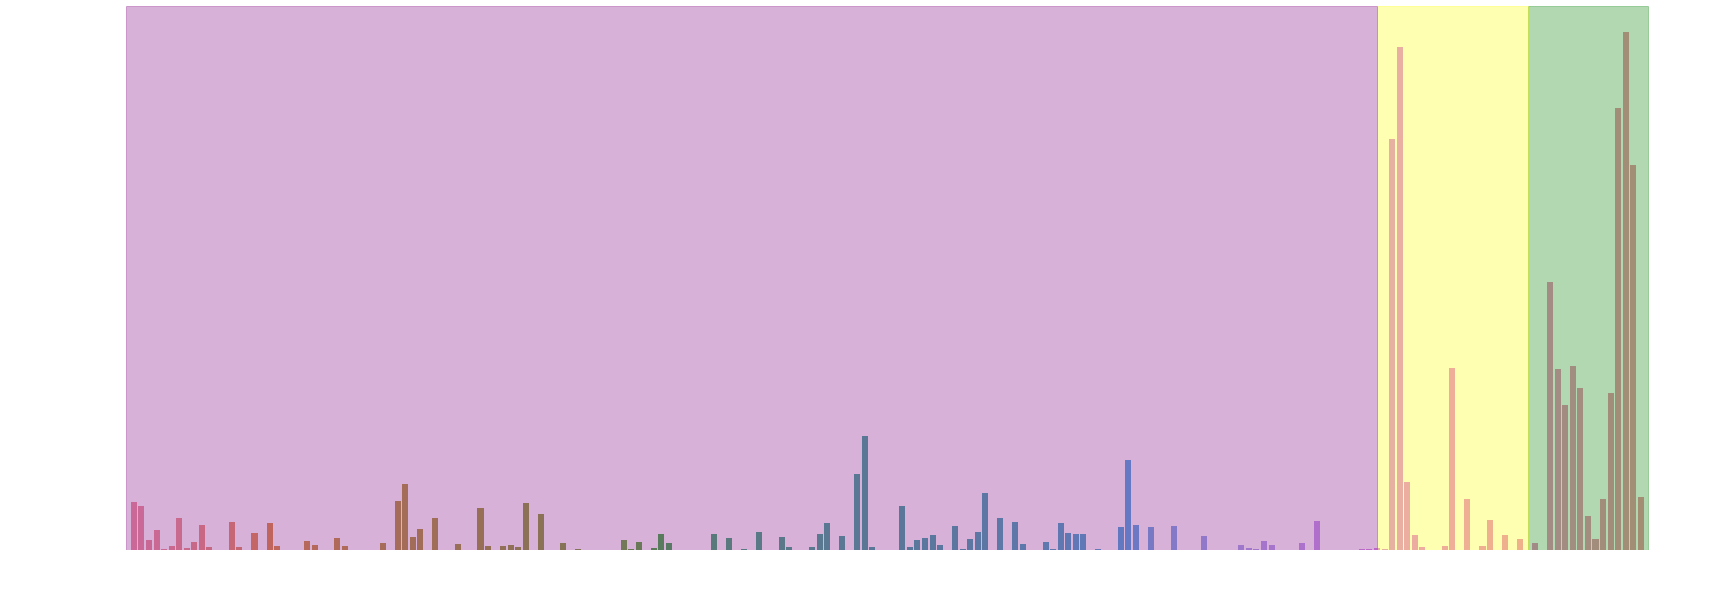

In [146]:
dims = (30.0, 10.0)
fig, ax = pyplot.subplots(figsize=dims)
imp = pd.DataFrame(list(zip(theme_regressor.feature_importances_, X_encoded_themes.columns)), columns=['importance', 'feature'])
g= sns.barplot(ax=ax, x='feature', y='importance', data=imp)
plt.axvspan(185,201, color='green', alpha=0.3)
plt.axvspan(165,185, color='yellow', alpha=0.3)
plt.axvspan(-1,165, color='purple', alpha=0.3)
plt.axis('off')

* Yellow: self_gift_desc_ * features
* Green: thematic features (also person description)
* Purple: person description

In [119]:
f_importance = pd.DataFrame(list(zip(theme_regressor.feature_importances_, X_encoded_themes.columns)), columns=['importance', 'feature'])
f_importance.sort_values(by=['importance'], ascending=False).head(10)

,importance,feature
198,0.094027,thematic_7
168,0.091423,OUTPUT:self_gift_desc_12_1.0
197,0.080276,thematic_6
167,0.074654,OUTPUT:self_gift_desc_12_0.0
199,0.069905,thematic_8
188,0.048636,OUTPUT:person_age
191,0.033484,thematic_0
175,0.033052,OUTPUT:self_wish_to_give_0.0
189,0.032845,OUTPUT:self_age
192,0.029390,thematic_1


Now we can see that feature importance is really changed. According to our tests, recommendations are also tend to be more suitable.

## Conclusion

We implemented basic solution. At this moment there are exist some problems.
1. Bias to electronic devices due to the size of the datasets and people nature
2. The second problem. I'll illustrate this problem here

Let's find the amount of parameter combinations and number of unique combinations in our dataset

In [120]:
gift_ques_names_list = ['OUTPUT:self_gift_desc_1',
                        'OUTPUT:self_gift_desc_2',
                        'OUTPUT:self_gift_desc_3',
                        'OUTPUT:self_gift_desc_4',
                        'OUTPUT:self_gift_desc_5',
                        'OUTPUT:self_gift_desc_6',
                        'OUTPUT:self_gift_desc_7',
                        'OUTPUT:self_gift_desc_8',
                        'OUTPUT:self_gift_desc_9',
                        'OUTPUT:self_gift_desc_10',
                        'OUTPUT:self_gift_desc_11',
                        'OUTPUT:self_gift_desc_12',
                        'OUTPUT:self_gift_desc_13',
                       ]

gift_ques = X [gift_ques_names_list]

gift_ques

,OUTPUT:self_gift_desc_1,OUTPUT:self_gift_desc_2,OUTPUT:self_gift_desc_3,OUTPUT:self_gift_desc_4,OUTPUT:self_gift_desc_5,OUTPUT:self_gift_desc_6,OUTPUT:self_gift_desc_7,OUTPUT:self_gift_desc_8,OUTPUT:self_gift_desc_9,OUTPUT:self_gift_desc_10,OUTPUT:self_gift_desc_11,OUTPUT:self_gift_desc_12,OUTPUT:self_gift_desc_13
0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0
2,1.0,2.0,1.0,1.0,0.0,2.0,1.0,3.0,1.0,1.0,0.0,0.0,4.0
4,0.0,0.0,0.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,0.0
6,1.0,0.0,0.0,1.0,4.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,5.0
8,0.0,0.0,0.0,1.0,4.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0
10,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
12,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
14,1.0,0.0,1.0,1.0,0.0,2.0,1.0,3.0,1.0,1.0,0.0,1.0,2.0
16,0.0,0.0,0.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0
18,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


In [121]:
# all possible combinations
combinations = 1

for key in gift_ques.keys ():
    combinations = combinations * len (set (gift_ques [key]))
    #print (len (set (gift_ques [key])))

combinations # VERY VERY big value

1105920

In [122]:
# the number of unique combinations in dataset
gift_ques_list = []
unique_strings = []
gift_ques_unique = []

for i in range (0, len (gift_ques)):
    newstr = str ((gift_ques [i:i + 1]).values [0])
    
    if newstr not in unique_strings:
        unique_strings.append (newstr)
        gift_ques_unique.append (gift_ques [i:i + 1])

for i in range (0, len (gift_ques)):   
    gift_ques_list.append (str ((gift_ques [i:i + 1]).values [0]))

unique = []

for answer in gift_ques_list:
    if answer not in unique:
        unique.append (answer)

len(unique)

724

So, according to this we have ~1000 instances and 724 different categories. 

It seems like the big amount of categories can have only one example in it. This is bad because we here are studying "statistical learning" and we don't have enough statsitics;) Though we achieved to get model which is dependent not only on gift_description features. So the model doesn't predict just one most valuable class.

Let's plot the distribution of predictions. To prove that our model doesn't predict the most valuable class

In [150]:
clf = Lasso(random_state=42, alpha=0.1)
clf.fit(X_encoded, y_frame.target)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)

In [151]:
Y = data['OUTPUT:self_gift_mark_2']
X = data.drop('OUTPUT:self_gift_mark_2', axis=1) 

leave = ['OUTPUT:person_age', 'OUTPUT:self_age']
to_onehot = X.drop(['OUTPUT:person_age', 'OUTPUT:self_age'], axis=1).columns.values

X_ = X.copy ()

results = []

#тут надо в цикле не энкодить все, но я не знаю, как
#from tqdm import tqdm
for i in range (0, len (gift_ques_unique)):
    if (i % 50 == 0):
        print (i, "of", len (gift_ques_unique))

    for name in gift_ques_names_list:
        #X_.at [0, name] = gift_ques.loc [[i * 2]] [name].values [0]
        X_.at [0, name] = gift_ques_unique [i] [name].values [0]

    onehotencoded = pd.get_dummies(X_[to_onehot].astype(str))

    to_binarize = []

    binarized = data[to_binarize].copy()
    binarize_set(binarized)

    X_encoded_ = pd.concat([onehotencoded, X_[leave]], axis=1)

    pred = clf.predict (X_encoded_.iloc [[0]])

    results.append ((i, pred [0]))

0 of 724
50 of 724
100 of 724
150 of 724
200 of 724
250 of 724
300 of 724
350 of 724
400 of 724
450 of 724
500 of 724
550 of 724
600 of 724
650 of 724
700 of 724


In [152]:
values = []
for el in list(map(list, results)):
    values.append(el[1])

(array([  7.,  34.,  74., 116., 163., 128.,  74.,  65.,  42.,  21.]),
 array([ 83.66943901,  85.31395463,  86.95847024,  88.60298586,
         90.24750147,  91.89201709,  93.5365327 ,  95.18104832,
         96.82556393,  98.47007955, 100.11459516]),
 <a list of 10 Patch objects>)

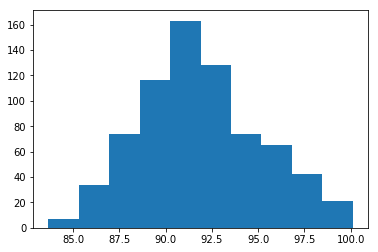

In [153]:
plt.hist(values)

Finally we see some ways to improve our solution:
1. More data
2. Decrease the number of different categories
3. Try to gather data from another side of barricades. Implement poll that will be answered by people who were supplied with a gift